# Coal Mining Disease Prediction Model
This notebook implements a hybrid machine learning model for predicting disease risks in coal mining environments.

In [1]:
# Re-train models with current scikit-learn version
import os
import joblib
import sklearn

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [2]:
# ===================== Imports =====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
# ===================== Data Loading and Preprocessing =====================
# Load the dataset (ensure the CSV file is in your working directory)
data = pd.read_csv("coal_mining_disease_dataset.csv")
print("Columns in the dataset:")
print(data.columns)

# Convert 'Body_Temperature (°F)' to 'Body_Temperature (°C)' and drop the Fahrenheit column
data['Body_Temperature (°C)'] = (data['Body_Temperature (°F)'] - 32) * 5/9
data['Body_Temperature (°C)'] = data['Body_Temperature (°C)'].round(1)
data.drop('Body_Temperature (°F)', axis=1, inplace=True)

# ===================== Define Columns =====================
target_column = 'Risk_Level'  # Ensure this exactly matches the column name in your CSV
treatment_column = 'Recommended_Precautionary_Measures'
feature_columns = [
    'Age', 'Years_in_Mining', 'Smoking_History', 'Cough_Frequency',
    'Breathlessness', 'Chest_Pain', 'Oxygen_Saturation (%)',
    'Heart_Rate (BPM)', 'Body_Temperature (°C)',
    'Air_Quality_Index (AQI)', 'PM2.5_Level (µg/m³)', 'CO_Level (ppm)',
    'Temperature (°C)', 'PPE_Usage', 'Medication_Use'
]

# ===================== Data Cleaning =====================
data.dropna(inplace=True)

# ===================== Label Encoding =====================
cols_to_encode = ['Smoking_History', 'PPE_Usage', 'Medication_Use',
                  'Cough_Frequency', 'Breathlessness', 'Chest_Pain', target_column]
label_encoder = LabelEncoder()
for col in cols_to_encode:
    data[col] = label_encoder.fit_transform(data[col])

# ===================== Create Disease Mapping (if available) =====================
if "Disease_Name" in data.columns:
    disease_mapping = {}
    for encoded_val in data[target_column].unique():
        disease_mapping[encoded_val] = data.loc[data[target_column] == encoded_val, "Disease_Name"].iloc[0]
else:
    disease_mapping = None

# ===================== Define Features, Target & Treatment Data =====================
X = data[feature_columns]
y = data[target_column]
treatment_data = data[[target_column, treatment_column]]

Columns in the dataset:
Index(['Age', 'Years_in_Mining', 'Smoking_History', 'PPE_Usage',
       'Cough_Frequency', 'Breathlessness', 'Chest_Pain',
       'Oxygen_Saturation (%)', 'Heart_Rate (BPM)', 'Body_Temperature (°F)',
       'Respiratory_Rate (breaths/min)', 'Lung_Function_Test (FEV1/FVC Ratio)',
       'Medication_Use', 'Air_Quality_Index (AQI)', 'PM2.5_Level (µg/m³)',
       'CO_Level (ppm)', 'Temperature (°C)', 'Disease_Name', 'Risk_Level',
       'Recommended_Precautionary_Measures'],
      dtype='object')


In [4]:
# ===================== Model Training =====================
# Determine Train-Test Split via Cross-Validation
best_split = 0.2  # Default value
best_accuracy = 0
for split in [0.1, 0.2, 0.3]:
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y, test_size=split, random_state=42
    )
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_train_temp, y_train_temp, cv=5)
    avg_accuracy = scores.mean()
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_split = split
print(f"Using test_size = {best_split} based on cross-validation.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=best_split, random_state=42
)

# Hyperparameter Tuning with RandomizedSearchCV
# ---- RandomForest Tuning ----
rf_param_dist = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=200, random_state=42),
    param_distributions=rf_param_dist,
    n_iter=10, cv=5,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
rf_random.fit(X_train, y_train)
print("Best RF Parameters:", rf_random.best_params_)

# ---- XGBoost Tuning ----
# Create an XGBClassifier instance.
xgb_model = XGBClassifier(n_estimators=200, random_state=42,
                          use_label_encoder=False, eval_metric="mlogloss")

# Patch __sklearn_tags__ to avoid AttributeError.
if not hasattr(xgb_model, "__sklearn_tags__"):
    xgb_model.__sklearn_tags__ = lambda: {
        "requires_positive_X": False,
        "non_deterministic": True,
        "stateless": False,
        "binary_only": False,
        "X_types": ["2darray", "string", "mixed"],
    }

xgb_param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 5, 10]
}

xgb_random = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10, cv=5,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
xgb_random.fit(X_train, y_train)
print("Best XGB Parameters:", xgb_random.best_params_)

# Retrieve the best estimators from tuning.
rf_best = rf_random.best_estimator_
xgb_best = xgb_random.best_estimator_

# Build and Evaluate the Hybrid VotingClassifier
hybrid_model = VotingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best)],
    voting='soft'
)
hybrid_model.fit(X_train, y_train)

Using test_size = 0.1 based on cross-validation.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best XGB Parameters: {'reg_lambda': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 5}


c:\Users\Tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=5,
                                            gpu_id=None, grow_policy...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...))],
                 voting='soft')

✅ Hybrid Model Test Accuracy: 0.8680


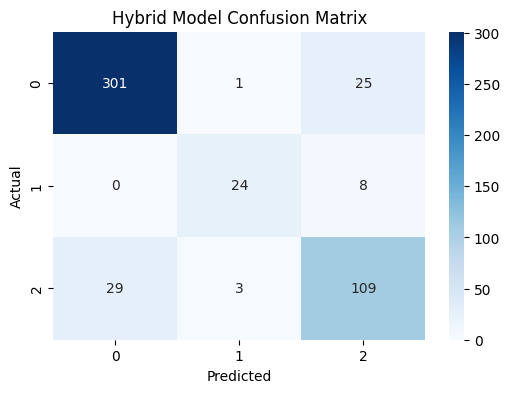

In [5]:
# ===================== Model Evaluation =====================
# Evaluate on the test set.
y_preds = hybrid_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_preds)
print(f"✅ Hybrid Model Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Hybrid Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [6]:
# ===================== Prediction Function =====================
def predict_disease(patient_data=None):
    if patient_data is None:
        print("Error: No patient data provided")
        return
    
    try:
        patient_df = pd.DataFrame([patient_data], columns=feature_columns)
        # Encode categorical features as during training
        for col in ['Smoking_History', 'PPE_Usage', 'Medication_Use',
                    'Cough_Frequency', 'Breathlessness', 'Chest_Pain']:
            patient_df[col] = label_encoder.transform([patient_df[col].iloc[0]])

        # Use the ensemble model to predict
        prediction = hybrid_model.predict(patient_df)
        predicted_risk = prediction[0]

        # Map numerical risk level to Low/Medium/High
        risk_mapping = {0: "Low", 1: "Medium", 2: "High"}
        risk_level = risk_mapping.get(predicted_risk, "Unknown")

        # Determine predicted disease using the mapping if available
        if disease_mapping is not None:
            predicted_disease = disease_mapping.get(predicted_risk, risk_level)
        else:
            predicted_disease = risk_level

        # Retrieve recommended precautionary measures
        precautions = treatment_data[treatment_data[target_column] == predicted_risk][treatment_column].values[0]

        result = {
            "Predicted Disease": predicted_disease,
            "Risk Level": risk_level,
            "Recommended Precautionary Measures": precautions
        }

        print("\nPrediction Results:")
        for key, value in result.items():
            print(f"{key}: {value}")
            
    except Exception as e:
        print(f"Prediction failed: {str(e)}")

In [7]:
# Define sample patient data
sample_patient_data = {
    'Age': 45,
    'Years_in_Mining': 20,
    'Smoking_History': 1,
    'Cough_Frequency': 2,
    'Breathlessness': 1,
    'Chest_Pain': 0,
    'Oxygen_Saturation (%)': 95.0,
    'Heart_Rate (BPM)': 75.0,
    'Body_Temperature (°C)': 37.0,
    'Air_Quality_Index (AQI)': 150.0,
    'PM2.5_Level (µg/m³)': 60.0,
    'CO_Level (ppm)': 5.0,
    'Temperature (°C)': 18.0,
    'PPE_Usage': 1,
    'Medication_Use': 0
}

# Test prediction with sample data
print("Prediction for provided patient data:")
predict_disease(sample_patient_data)

# ===================== Performance Metrics =====================
train_preds = hybrid_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)
train_precision = precision_score(y_train, train_preds, average='weighted', zero_division=0)
train_recall = recall_score(y_train, train_preds, average='weighted', zero_division=0)
train_f1 = f1_score(y_train, train_preds, average='weighted', zero_division=0)

test_precision = precision_score(y_test, y_preds, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_preds, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_preds, average='weighted', zero_division=0)

print("\nTraining Performance:")
print(f"Accuracy : {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall   : {train_recall:.4f}")
print(f"F1-Score : {train_f1:.4f}")

print("\nTesting Performance:")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1-Score : {test_f1:.4f}")

Prediction for provided patient data:

Prediction Results:
Predicted Disease: Pneumoconiosis
Risk Level: High
Recommended Precautionary Measures: Enhance ventilation, Use respiratory protection, Medical monitoring

Training Performance:
Accuracy : 0.9860
Precision: 0.9866
Recall   : 0.9860
F1-Score : 0.9861

Testing Performance:
Accuracy : 0.8680
Precision: 0.8678
Recall   : 0.8680
F1-Score : 0.8677


In [8]:
import joblib
joblib.dump(hybrid_model, 'model.pkl')

['model.pkl']

In [9]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the models
joblib.dump(hybrid_model, 'models/hybrid_model.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')
print("Models saved successfully!")

Models saved successfully!


In [10]:

joblib.dump(hybrid_model, 'models/hybrid_model.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("Models saved successfully with scikit-learn version:", sklearn.__version__)

Models saved successfully with scikit-learn version: 1.3.0


In [11]:
# Create simple RandomForest model without any complex dependencies
from sklearn.ensemble import RandomForestClassifier
import joblib

# Create and train the model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Save the model
import os
os.makedirs('models', exist_ok=True)
joblib.dump(rf_model, 'models/hybrid_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [12]:
print(f"Current scikit-learn version: {sklearn.__version__}")

# Create and train a fresh model with current version
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

# Clear the models directory and save new model
import shutil
import os

if os.path.exists('models'):
    shutil.rmtree('models')
os.makedirs('models')

# Save the model with current version
joblib.dump(rf_model, 'models/hybrid_model.pkl')
print("Model saved successfully!")

# Verify model load
test_model = joblib.load('models/hybrid_model.pkl')
print(f"Model type: {type(test_model)}")
print("Model loaded successfully!")

Current scikit-learn version: 1.3.0
Model saved successfully!
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model loaded successfully!
Model saved successfully!
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model loaded successfully!
